# HW2 - Data From The Web

## 1. Web Scraping 

We will first write all functions needed to extract the data from the websites and demonstrate how they work. Then we will complete the assignment using them.

In [1]:
import requests as rq
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import pandas as pd
import seaborn
import pickle
%matplotlib inline
import os.path
from googletrans import Translator
import time
import re

TOP_UNI_URL = 'https://www.topuniversities.com'
TIMES_URL = 'https://www.timeshighereducation.com'

## Helper functions

#### Create dataframe with the scrapped information 

In [2]:
def create_dataframe(data):
    df = pd.DataFrame.from_dict(data).set_index('Rank')
    df = df[['Name', 'Country', 'Region', 'Tot_Stud', 'Inter_Stud', 'Tot_Mem', 'Inter_Mem']]
    return df

#### Calculate Member/Student ratio dataframe

In [3]:
def best_member_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Members/Students ratio'] =df['Tot_Mem'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Members/Students ratio'], ascending=False)
    
    best_ratio[:20]['Members/Students ratio'].plot.bar(title='Top 20 Universities on Member/Student ratio')
    plt.show()
    return best_ratio

#### Calculate International/Student ratio dataframe

In [4]:
def best_international_student_ratio(df):
    best_ratio = df.copy()
    best_ratio['Int_Stud ratio'] = df['Inter_Stud'] / df['Tot_Stud']
    best_ratio = best_ratio.set_index('Name').sort_values(['Int_Stud ratio'], ascending=False)
    best_ratio[:20]['Int_Stud ratio'].plot.bar(title='Top 20 Universities on International Students ratio')
    plt.show()
    return best_ratio

#### Plot ratios by country and region

In [5]:
def plot_ratios_by_country_region(member_student, international_student): 
    plot_country_df_a = member_student.groupby(['Country'])['Members/Students ratio'].mean()
    plot_country_df_a = plot_country_df_a.sort_values(ascending=False)

    plot_country_df_b = international_student.groupby(['Country'])['Int_Stud ratio'].mean()
    plot_country_df_b = plot_country_df_b.sort_values(ascending=False)

    plot_region_df_a = member_student.groupby(['Region'])['Members/Students ratio'].mean()
    plot_region_df_a = plot_region_df_a.sort_values(ascending=False)

    plot_region_df_b = international_student.groupby(['Region'])['Int_Stud ratio'].mean()
    plot_region_df_b = plot_region_df_b.sort_values(ascending=False)

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace = 1)
    plot_country_df_a.plot.bar(ax=axes[0, 0], title='Member/Student ratio by country')
    plot_country_df_b.plot.bar(ax=axes[0, 1], title='International Student ratio by Country')
    plot_region_df_a.plot.bar(ax=axes[1, 0], title='Member/Student ratio by region')
    plot_region_df_b.plot.bar(ax=axes[1, 1], title='International Student ratio by Region')
    plt.show()

This function is used to ransform the names of the universities in order to match university names the best way posible. Here is what we did:
1. Removed the special characters from the names `., -, é, (, )...`
2. Removed stopwords such as `the`, `of`
3. Removed extra empty spaces
4. Translated names from foreign languages with the library `googletrans`
5. Removed duplicated words in university names such as `University of Zurich, Zurich`
 <p id="2"/> 

In [6]:
def rreplace(s):
    d = {}
    
    for w in s.split(): 
        w = w.strip(' ')
        
        if w in d.keys(): 
            d[w] += 1
        else:
            d[w] = 0
    
    for key, value in d.items():
        li = s.rsplit(key, value)
        s = ''.join(li)
    
    return s.strip()

def clean_name(name):
    to_replace = {'the':'', 'of':'', 'é':'e', '-':' ', '—':' ', '–':' ', '’':'',\
                  '\'':'', '.':'', ',':'', '&':' and ', '(':'', ')':''}
    
    translator = Translator(service_urls=[
        'translate.google.ch'
    ])
    
    name = translator.translate(name).text
    name = name.lower()
    name = rreplace(name)
    
    for key, value in to_replace.items(): 
        name = name.replace(key, value)
    
    name = re.sub(r"\s+", ' ', name)
    name = name.strip(' ')
    print(name)
    
    return name

### 1.1 Top Universities Website

With these functions we obtain the amount of faculty members (total & international) and students (total & international)

In [7]:
def get_num_members(soup):
    return int(soup.find('div', class_='total faculty').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='inter faculty').find('div', class_='number').text.strip().replace(',', ''))

In [8]:
def get_num_students(soup):
    return int(soup.find('div', class_='total student').find('div', class_='number').text.strip().replace(',', '')),\
           int(soup.find('div', class_='total inter').find('div', class_='number').text.strip().replace(',', ''))

### Scrape data from the Top universities ranking 

After a look with Postman on the webside, we realised that the ranking table data were not given on the page but retrieved and added with a script on a json file. We then had to directly get this file to obtain the information we need for this assignment. The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag.

In order to avoid latency during testing we keep the data in a .pickle  file. In order to scrape the website again we need to delete this file. 

At this point we directly clean and keep the university name for later comparison.  

In [9]:
names = []
g = 0

if not os.path.exists('topunis.pickle'): 
    TOP_WORLD_RANKING_FILE = TOP_UNI_URL + '/sites/default/files/qs-rankings-data/357051.txt'
    ranking_top_uni = rq.get(TOP_WORLD_RANKING_FILE).json().get('data')
    top_unis = []
    for uni in ranking_top_uni[:200]:
        g +=1
        
        # throttling the research to avoid being kicked by the website
        if g % 20 == 0: 
            time.sleep(30)
        name = clean_name(uni.get('title'))
        names.append(name)
        top_unis.append({'Name' : name, 'Rank' : uni.get('rank_display').replace('=', ''), 
                         'Country' : uni.get('country'), 'Region' : uni.get('region'), 'Url' : uni.get('url')})
        
    problematic_uni = []
    for uni in top_unis:
        page = rq.get(TOP_UNI_URL + uni['Url'])
        soup = BeautifulSoup(page.text, 'html.parser')
        try:
            tot_mem, inter_mem = get_num_members(soup)
            tot_stud, inter_stud = get_num_students(soup)
            uni['Tot_Mem'] = tot_mem
            uni['Inter_Mem'] = inter_mem
            uni['Tot_Stud'] = tot_stud
            uni['Inter_Stud'] = inter_stud
        except AttributeError: 
            problematic_uni.append(top_unis.index(uni))
            print('Could not fetch data from:', uni['Name'])
    #Fill in the missing information for "problematic unis"
    nyu = top_unis[problematic_uni[0]]
    nyu['Tot_Mem'] = 7717
    nyu['Inter_Mem'] = 604
    nyu['Tot_Stud'] = 43860
    nyu['Inter_Stud'] = 11593

    bang = top_unis[problematic_uni[1]]
    bang['Tot_Mem'] = 423
    bang['Inter_Mem'] = 0
    bang['Tot_Stud'] = 4071
    bang['Inter_Stud'] = 47
    
    with open('topunis.pickle', 'wb') as out:
        pickle.dump(top_unis, out)
else: 
    with open('topunis.pickle', 'rb') as data: 
        top_unis = pickle.load(data)

We noticed that the supplementary data was present for all universities except for two of them. We had to go to their website directly and fill in the data manually 

In [10]:
#Create a dataframe with the scraped data
top_uni_df = create_dataframe(top_unis)
top_uni_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,massachusetts institute technology mit,United States,North America,11067,3717,2982,1679
2,stanford university,United States,North America,15878,3611,4285,2042
3,harvard university,United States,North America,22429,5266,4350,1311
4,california institute technology caltech,United States,North America,2255,647,953,350
5,university cambridge,United Kingdom,Europe,18770,6699,5490,2278


#### 1.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

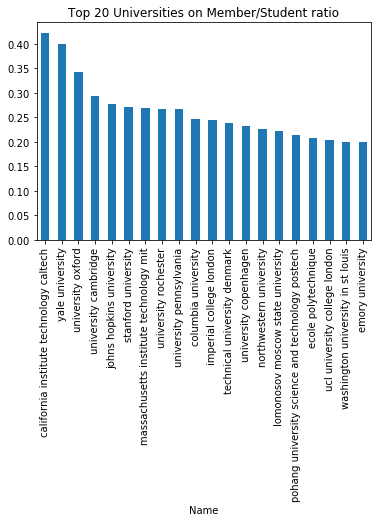

In [11]:
member_student_ratio = best_member_student_ratio(top_uni_df)

#### 1.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

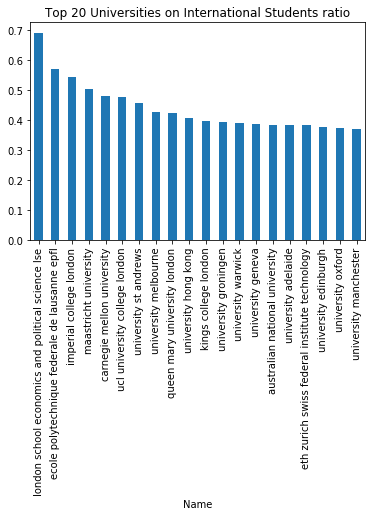

In [12]:
international_student_ratio = best_international_student_ratio(top_uni_df)

#### 1.2.c and 1.2.d Same questions aggregating by country and region

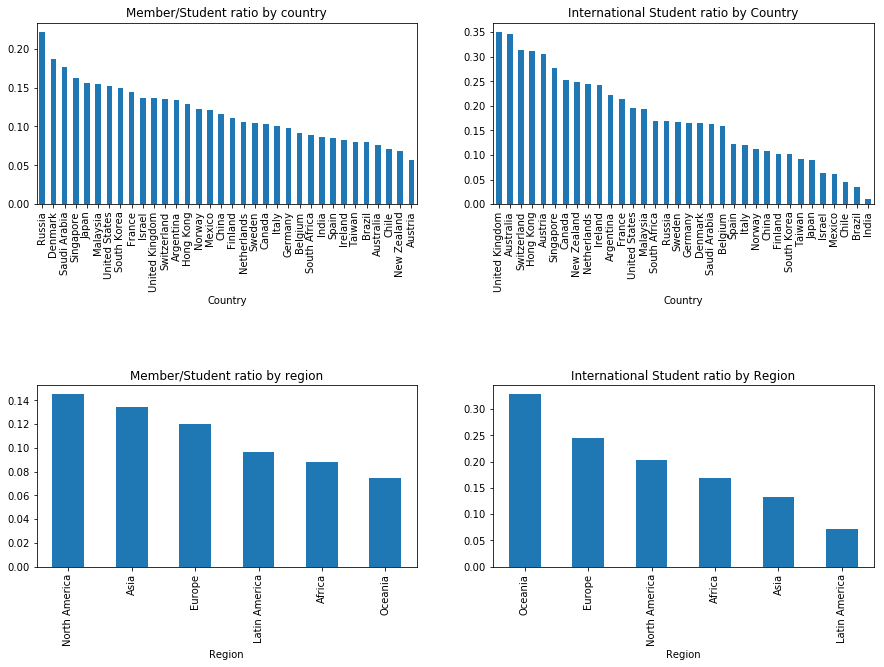

In [13]:
plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 2.1 Times Higher Education Website
 <p id="1"/> 

The file returned by the request is a simple json object with the list of universities ordered by rank after the 'Data' tag. But this time the *Region* is not given by the website, no even on the specific pages. But this time it contains everything else, no need to scrap the specific pages.

Here also to avoid latency during testing we keep the data in a .pickle  file. In order to scrape the website again we need to delete this file. 

The university name is cleaned and translated during the scraping. We also check if the university name is part of a university name that appeared in the previous ranking (such as `massachusetts institute of technology` in one ranking and `massachusetts institute of technology mit` in the other) and vice versa, if it is the case we keep the name that appeared in the previous ranking. 

In [14]:
if not os.path.exists('toptimes.pickle'): 
    
    TOP_TIMES_RANKING_FILE = TIMES_URL + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
    ranking_top_times = rq.get(TOP_TIMES_RANKING_FILE).json().get('data')

    top_times = []
    for uni in ranking_top_times[:200]:
        g +=1
        # throttling the research to avoid being kicked by the website
        if g % 20 == 0: 
            time.sleep(30)
            
        name = clean_name(uni.get('name'))
        for n in names: 
            if name in n: 
                name = n
                break
            elif n in name: 
                name = n
                break
        top_times.append({'Name' : name, 'Rank' : uni.get('rank').replace('=', ''), 
                          'Country' : uni.get('location'), 'Region' : None,
                          'Tot_Stud' : int(uni.get('stats_number_students').replace(',', '')), 
                          'Inter_Stud' : round(int(uni.get('stats_number_students').replace(',', '')) * int(uni.get('stats_pc_intl_students').replace('%', '')) / 100),
                          'Tot_Mem' : round(int(uni.get('stats_number_students').replace(',', '')) / float(uni.get('stats_student_staff_ratio'))),
                          'Inter_Mem' : None})
    with open('toptimes.pickle', 'wb') as out:
        pickle.dump(top_times, out)
else: 
    with open('toptimes.pickle', 'rb') as data: 
        top_times = pickle.load(data)
    

In [15]:
#Create a dataframe with the scraped data
top_times_df = create_dataframe(top_times)
top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,None,20409,7755,1822,None
2,university cambridge,United Kingdom,None,18389,6436,1687,None
3,california institute technology caltech,United States,None,2209,596,340,None
3,stanford university,United States,None,15845,3486,2113,None
5,massachusetts institute technology mit,United States,None,11177,3800,1285,None


### Fill in the regions for the top times dataframe from top uni dataframe

To do this task we take the unique $country \mapsto region$ mappings from the first ranking. We can see that in the Top Universities ranking Luxembourg doesn't appear, so we have to map it by hand. Also Russia appears as `Russia` in the Top Universities ranking and as `Russian Federation` in the Top Times rankings. We also map it separately to have Europe as region. 

In [16]:
df = top_uni_df[['Country', 'Region']].groupby(['Country','Region'])

country_region = {}
for country, region in df.groups.keys(): 
    top_times_df.loc[top_times_df['Country'] == country, 'Region'] = region
    
top_times_df.loc[top_times_df['Country'] == 'Luxembourg', 'Region'] = 'Europe'
top_times_df.loc[top_times_df['Country'] == 'Russian Federation', 'Region'] = 'Europe'

top_times_df.head()

,Name,Country,Region,Tot_Stud,Inter_Stud,Tot_Mem,Inter_Mem
Rank,,,,,,,
1,university oxford,United Kingdom,Europe,20409,7755,1822,None
2,university cambridge,United Kingdom,Europe,18389,6436,1687,None
3,california institute technology caltech,United States,North America,2209,596,340,None
3,stanford university,United States,North America,15845,3486,2113,None
5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None


#### 2.2.a Which are the best universities in terms of ratio between faculty members and students ?
Here are the top 20

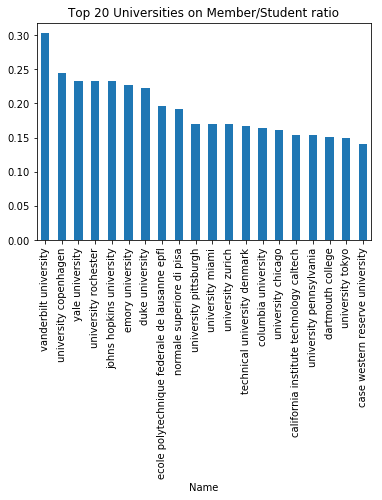

In [17]:
member_student_ratio = best_member_student_ratio(top_times_df)

#### 2.2.b Which are the best universities in terms of ratio of international students?
Here are the top 20

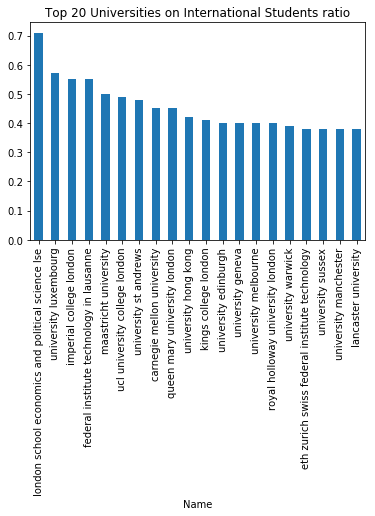

In [18]:
international_student_ratio = best_international_student_ratio(top_times_df)

#### 2.2.c and 2.2.d Same questions aggregating by country and region

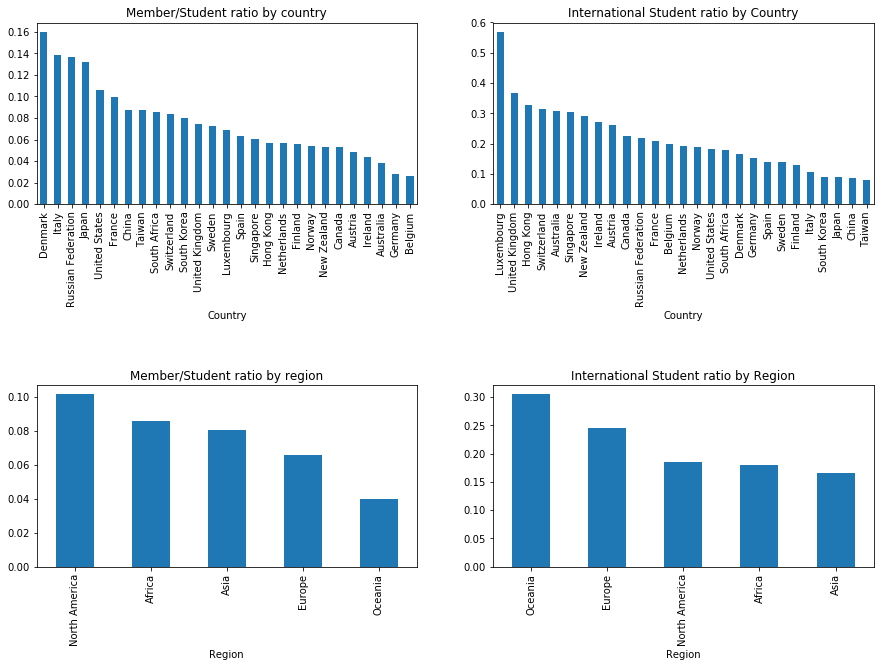

In [19]:
 plot_ratios_by_country_region(member_student_ratio, international_student_ratio)

### 3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

Here we merge the both universities based on their name. The names were cleaned in order to provide the best match and it is explaned earlier (<a href="#2">here</a>  and <a href="#1">here</a>). In order to keep the analysis simple we keep only the universities that appear in both rankings. To keep all the universities we just need to change the the how argument  to `how=outer`

With this way of merging the both ranking we keep `153` universities that appear in both rankings. 

In [20]:
merged_df = top_times_df.reset_index().merge(top_uni_df.reset_index(), on=['Name'], suffixes=('_Times', '_Unis'), how='inner')
merged_df.head()
merged_df["Rank_Times"] = pd.to_numeric(merged_df["Rank_Times"])
merged_df["Rank_Unis"] = pd.to_numeric(merged_df["Rank_Unis"])
merged_df

,Rank_Times,Name,Country_Times,Region_Times,Tot_Stud_Times,Inter_Stud_Times,Tot_Mem_Times,Inter_Mem_Times,Rank_Unis,Country_Unis,Region_Unis,Tot_Stud_Unis,Inter_Stud_Unis,Tot_Mem_Unis,Inter_Mem_Unis
0,1,university oxford,United Kingdom,Europe,20409,7755,1822,None,6,United Kingdom,Europe,19720,7353,6750,2964
1,2,university cambridge,United Kingdom,Europe,18389,6436,1687,None,5,United Kingdom,Europe,18770,6699,5490,2278
2,3,california institute technology caltech,United States,North America,2209,596,340,None,4,United States,North America,2255,647,953,350
3,3,stanford university,United States,North America,15845,3486,2113,None,2,United States,North America,15878,3611,4285,2042
4,5,massachusetts institute technology mit,United States,North America,11177,3800,1285,None,1,United States,North America,11067,3717,2982,1679
5,6,harvard university,United States,North America,20326,5285,2284,None,3,United States,North America,22429,5266,4350,1311
6,7,princeton university,United States,North America,7955,1909,958,None,13,United States,North America,8069,1793,1007,246
7,8,imperial college london,United Kingdom,Europe,15857,8721,1391,None,8,United Kingdom,Europe,16090,8746,3930,2071
8,9,university chicago,United States,North America,13525,3381,2181,None,9,United States,North America,13557,3379,2449,635
9,10,eth zurich swiss federal institute technology,Switzerland,Europe,19233,7309,1317,None,10,Switzerland,Europe,19815,7563,2477,1886


### 4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

We have at most four variables for the two rankings

* Amount of student
* Amount of International student
* Amount of members
* Amount of International members

which are distributed across **regions** and **countries**.

We had two starting points :

* the table of correlation
* the example in the problem statement

In [21]:
def color_for_cell(x):
    color = "black"
    x = np.abs(x)
    if x == 1.0:
        color = "white"
    if x < 0.8:
        color = "#999"
        
    return 'color: {}'.format(color)

merged_df.corr().style.applymap(color_for_cell)

There is no significant information from it, the only correlation we would guess is from series which represent the same underlying data. Let's try to plot together each numerical variable in a scatter plot to see if visually we can get some correlation

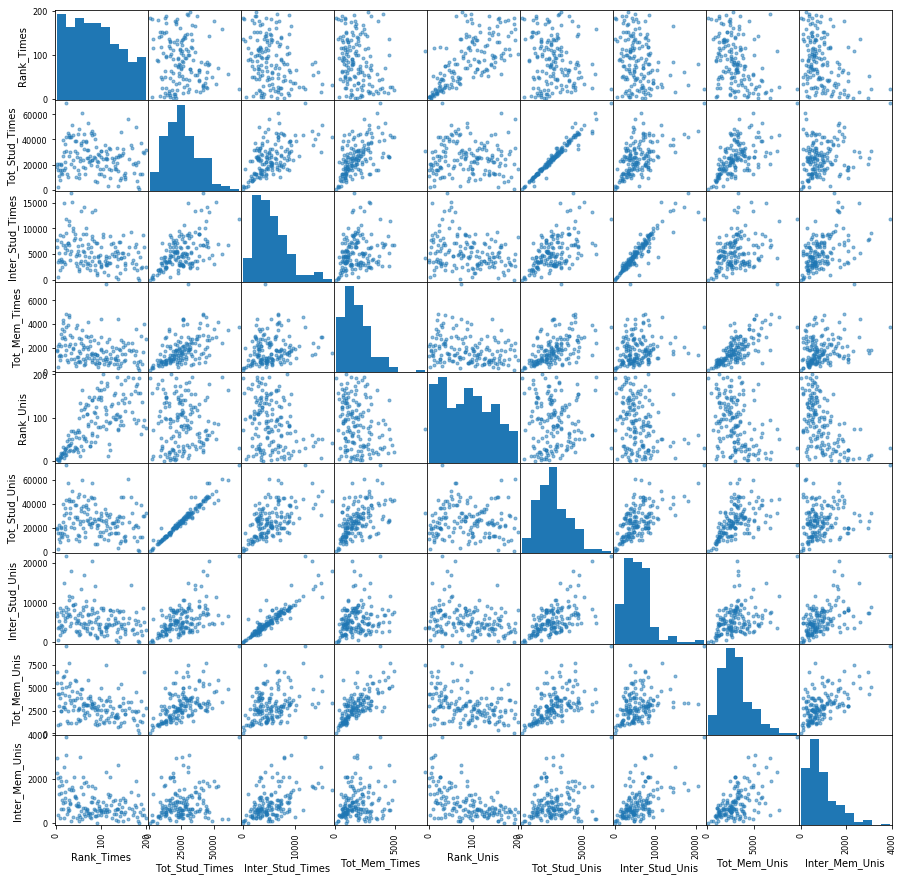

In [22]:
from pandas.tools.plotting import scatter_matrix


comparable_columns = merged_df.select_dtypes(exclude=['object']).columns
n_col = len(comparable_columns)

df = merged_df[merged_df.select_dtypes(exclude=['object']).columns]

scatter_matrix(df, alpha=0.5, figsize=(15,15))
plt.show()

Next we wanted to see if the amount of international members is somewhat related to the amount of international  students. We can see that the international students contribute largely to the international dimensions of the university. On the other hand the International members don't follow that. Even if there are a lot of international students in a university it doesn't mean that there are a lot of international.  

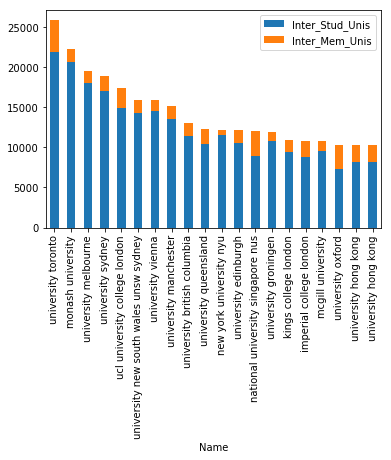

In [23]:
best_ratio = merged_df.copy()
best_ratio['International'] = merged_df['Inter_Stud_Unis'] +  merged_df['Inter_Mem_Unis']
best_ratio = best_ratio.set_index('Name').sort_values(['International'], ascending=False)
    
top_20 = best_ratio[['Inter_Stud_Unis', 'Inter_Mem_Unis']][:20]
top_20[['Inter_Stud_Unis','Inter_Mem_Unis']].plot.bar(stacked=True)
plt.show()

Here we plot the correlation between different variables that we find important. We cannot find a direct link between the ranking and the number of international students or the number of students. 

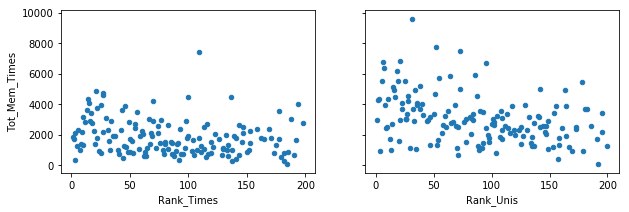

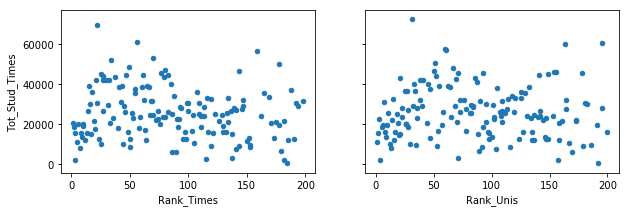

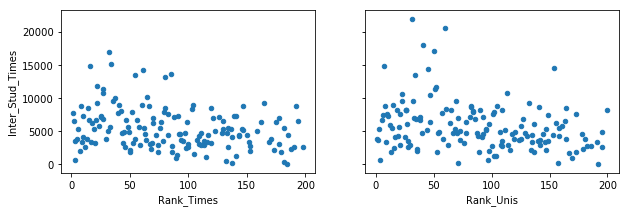

In [24]:
# Relation between the amount of student and the ranking
scatter_plots = [
    [
        dict(x="Rank_Times", y="Tot_Mem_Times"),
        dict(x="Rank_Unis", y="Tot_Mem_Unis")
    ],
    [
        dict(x="Rank_Times", y="Tot_Stud_Times"),
        dict(x="Rank_Unis", y="Tot_Stud_Unis")
    ],
    [
        dict(x="Rank_Times", y="Inter_Stud_Times"),
        dict(x="Rank_Unis", y="Inter_Stud_Unis")
    ]
]

height = 3
width = 10
for plot in scatter_plots:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width,height), sharey=True)
    
    for i, data in enumerate(plot):
        merged_df.plot(kind="scatter", x=data["x"], y=data["y"], ax=axes[i])
        
    plt.show()

# Discrete distribution of university per ranking per region

In this section, we wanted to see if we bucket (by 20 or 40 buckets) the universities by their ranking by region, if some pattern appears between the two ranking methods. The first two rows are with the Times ranking method, and the second two with the Unis ranking method. 

The main difference are for Europe and North America. It is expected since there is more university in the ranking from these two regions. We have made a second plot to be able to focus on them.

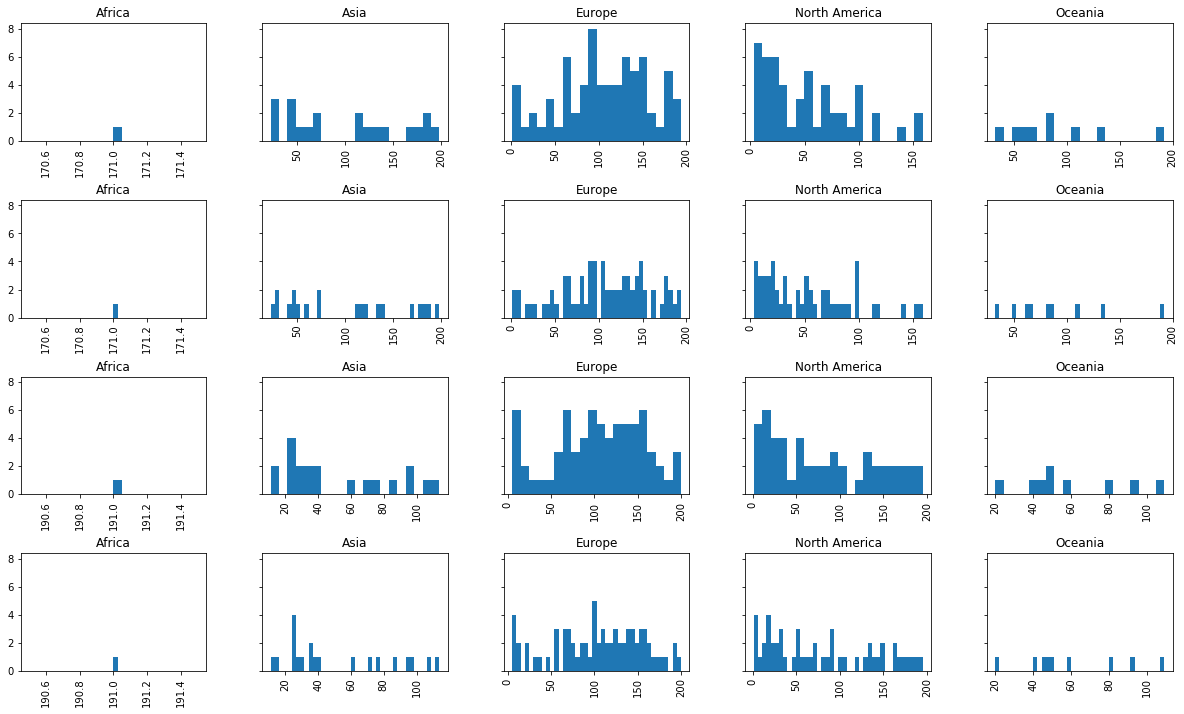

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20,12), sharey=True)
    
merged_df.hist(column="Rank_Times", by="Region_Times", bins=20, ax=axes[0])
merged_df.hist(column="Rank_Times", by="Region_Times", bins=40, ax=axes[1])

merged_df.hist(column="Rank_Unis", by="Region_Unis", bins=20, ax=axes[2])
merged_df.hist(column="Rank_Unis", by="Region_Unis", bins=40, ax=axes[3])

plt.show()

Here we notice that the distribution of North America get more or less uniform and it influences Europe's top and bottom ranking. The histograms in the first row are from the `times` ranking, the first two are with `20 bins` and the second two are with `40 bins`. The second row is from the `Top University` ranking with the same configuration as the first row.

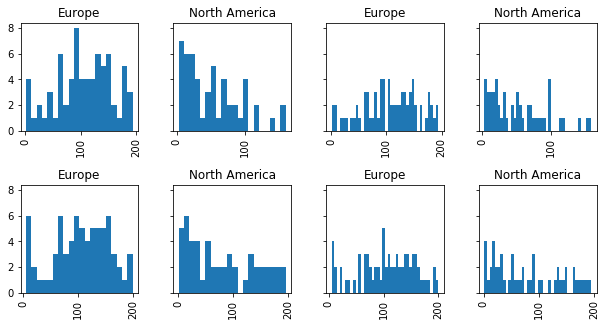

In [26]:
us_europe_df = merged_df[(merged_df["Region_Times"] == "Europe") | (merged_df["Region_Times"] == "North America")]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,5), sharey=True)

ax_20_times = [axes[0,0], axes[0,1]]
ax_20_unis = [axes[1,0], axes[1,1]]

ax_40_times = [axes[0,2], axes[0,3]]
ax_40_unis = [axes[1,2], axes[1,3]]

us_europe_df.hist(column="Rank_Times", by="Region_Times", bins=20, ax=ax_20_times)
us_europe_df.hist(column="Rank_Unis", by="Region_Unis", bins=20, ax=ax_20_unis)

us_europe_df.hist(column="Rank_Times", by="Region_Times", bins=40, ax=ax_40_times)
us_europe_df.hist(column="Rank_Unis", by="Region_Unis", bins=40, ax=ax_40_unis)

plt.show()

We also wanted to know if the ratio of international student get higher because of the ranking. Here are both rankings on the same plot. We did not get significant correlation except that the minimum is increased from the first place down to the 25th.

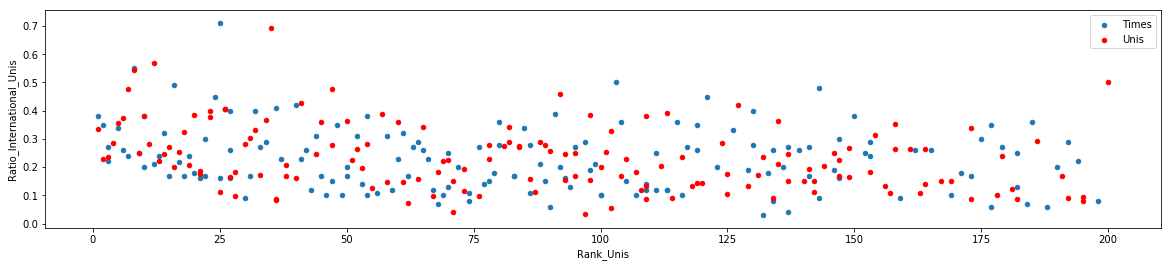

In [27]:
# Relation between the ratio of international student and the region/country

merged_df["Ratio_International_Times"] = merged_df['Inter_Stud_Times'] / merged_df['Tot_Stud_Times']
merged_df["Ratio_International_Unis"] = merged_df['Inter_Stud_Unis'] / merged_df['Tot_Stud_Unis']

ax = merged_df.plot(kind="scatter", x="Rank_Times", y="Ratio_International_Times", figsize=(20,4), label="Times")
merged_df.plot(kind="scatter", x="Rank_Unis", y="Ratio_International_Unis", ax=ax, color="r", label="Unis")

plt.show()

This plot doesn't provide a lot of information. 

### Given the ranking, plot the distribution of ratio of: 
1. international people in Times and Unis magazine
2. Ratio of international member 
3. Ratio of internation student

In [28]:
# Build the columns needed
merged_df["Total_Unis"] = merged_df["Tot_Stud_Unis"] + merged_df["Tot_Mem_Unis"]
merged_df["Inter_Unis"] = merged_df["Inter_Stud_Unis"] + merged_df["Inter_Mem_Unis"]

merged_df["ratio_international"] = merged_df["Inter_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_stud_total"] = merged_df["Inter_Stud_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_mem_total"] = merged_df["Inter_Mem_Unis"] / merged_df["Total_Unis"]
merged_df["ratio_international_stud"] = merged_df["Inter_Stud_Unis"] / merged_df["Tot_Stud_Unis"]
merged_df["ratio_international_mem"] = merged_df["Inter_Mem_Unis"] / merged_df["Tot_Mem_Unis"]

In order to dig deeper into this ratio comparissin we splitted the data by regions.

* First row of plots is both the ratio of international **member** and **student** by the rank (from the Unis ranking)
* Second row of plots is the ratio of international **student** by the rank (from both ranking)
* Third row of plots is for international **member** (for Unis rank only)

Findings:

* Surprisingly, in North america, international student ratio seems to be smaller than in Europe. Especially at top universities.
* Oceania get a higher than overall and constant 30% level of international student in both studies, **student** is especially flat, **member** is even higher
* Europe and Asia have very high level (>= 60% at top universities)

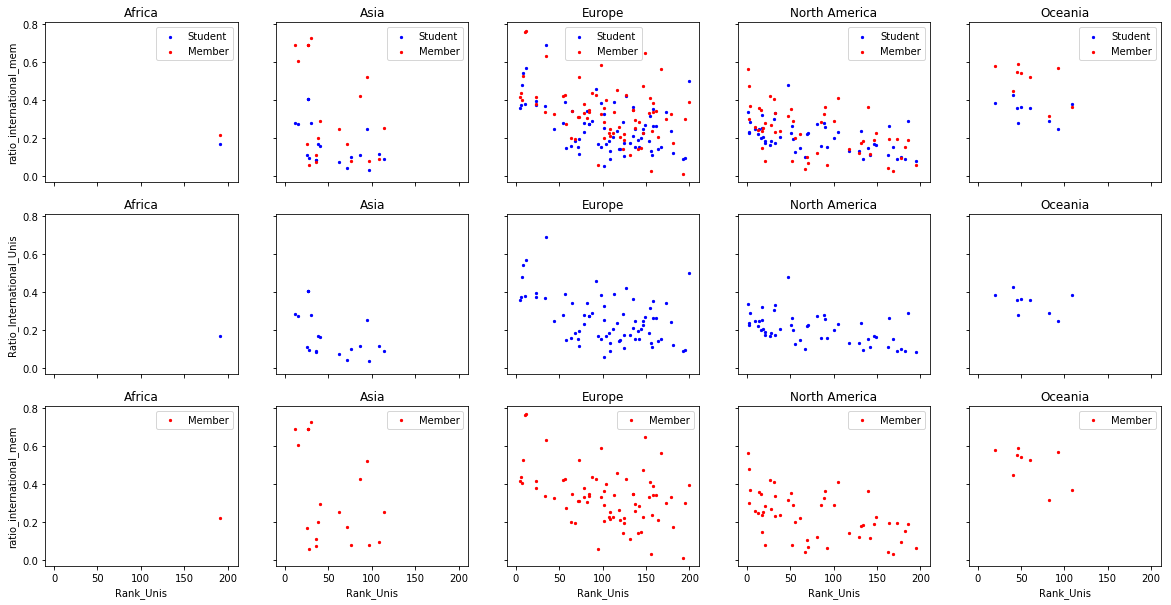

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10), sharey=True, sharex=True)

for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Unis", y="ratio_international_stud", ax=axes[0,i], color="b", s=5, label="Student")

for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Unis", y="ratio_international_mem", ax=axes[0,i], color="r", s=5, label="Member")

for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Unis", y="Ratio_International_Unis", ax=axes[1,i], color="b", s=5)
    
for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Unis", y="ratio_international_mem", ax=axes[2,i], color="r", s=5, label="Member")

# Amount of total international member and total people in Unis ranking and plot for ratio of international, ratio of international student and member

Ratio may erase some absolute values. So we also looked at how many international people where over the total in each regions and coutries. Let's compare those absolutes values with ratio, side-by-side.

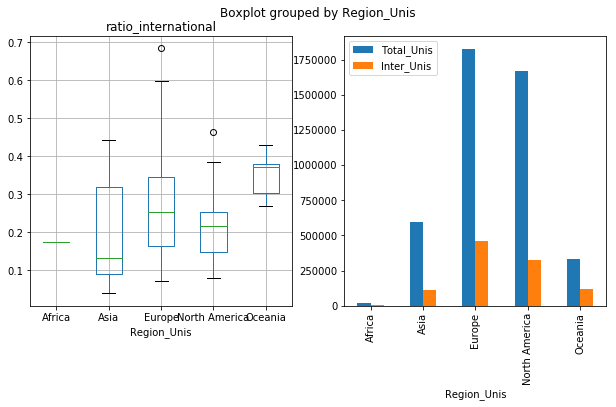

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

merged_df.boxplot(column="ratio_international", by="Region_Unis", ax=axes[0])
merged_df.groupby("Region_Unis").sum().plot.bar(y=["Total_Unis", "Inter_Unis"], ax=axes[1])

We also wanted to see if thoses ratios were corellated. We obtained a slight information that they were correlation between the ratio of total international people and the ratio of international students. But it is expected since they count more in the total values of international people there.

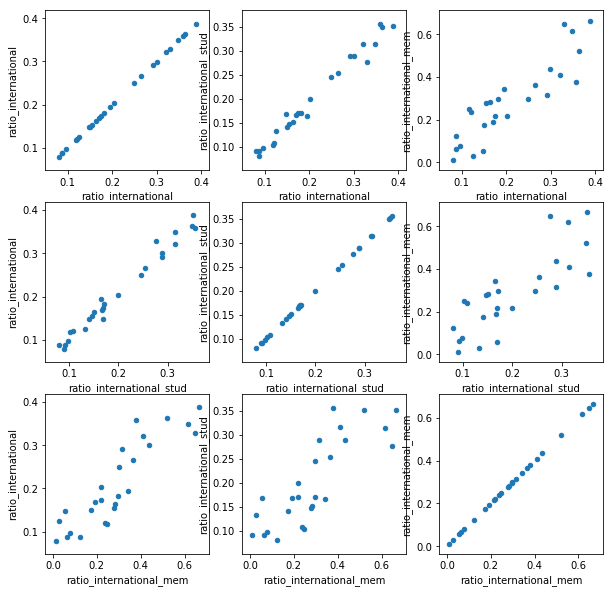

In [31]:
mean_ratio_by_country = merged_df.groupby("Country_Unis").mean()

columns = ["ratio_international", "ratio_international_stud", "ratio_international_mem"]
sides = len(columns)
fig, axes = plt.subplots(nrows=sides, ncols=sides, figsize=(10,10))

for i,x in enumerate(columns):
    for j,y in enumerate(columns):
        mean_ratio_by_country.plot(kind="scatter", x=x, y=y, ax=axes[i,j])

Without finding a correlations, we decided to do the average of thoses ratio by countries and sort them by the three kinds of ratios: global, student and member ratios. From the two lasts rows, we can compare the difference in positions

* Roughly half of the universities have more international **members** than student. It is expected since many more people undergraduates at home than somewhere else.
* Singapores has way more international **members** than student
* Russia, Italy and Spain are an outliers here, with less than half **members** ratio than **student**

Having those plots, we also plotted the difference between **members** and **student** ratio, which give a way more illustrative plot of those informations

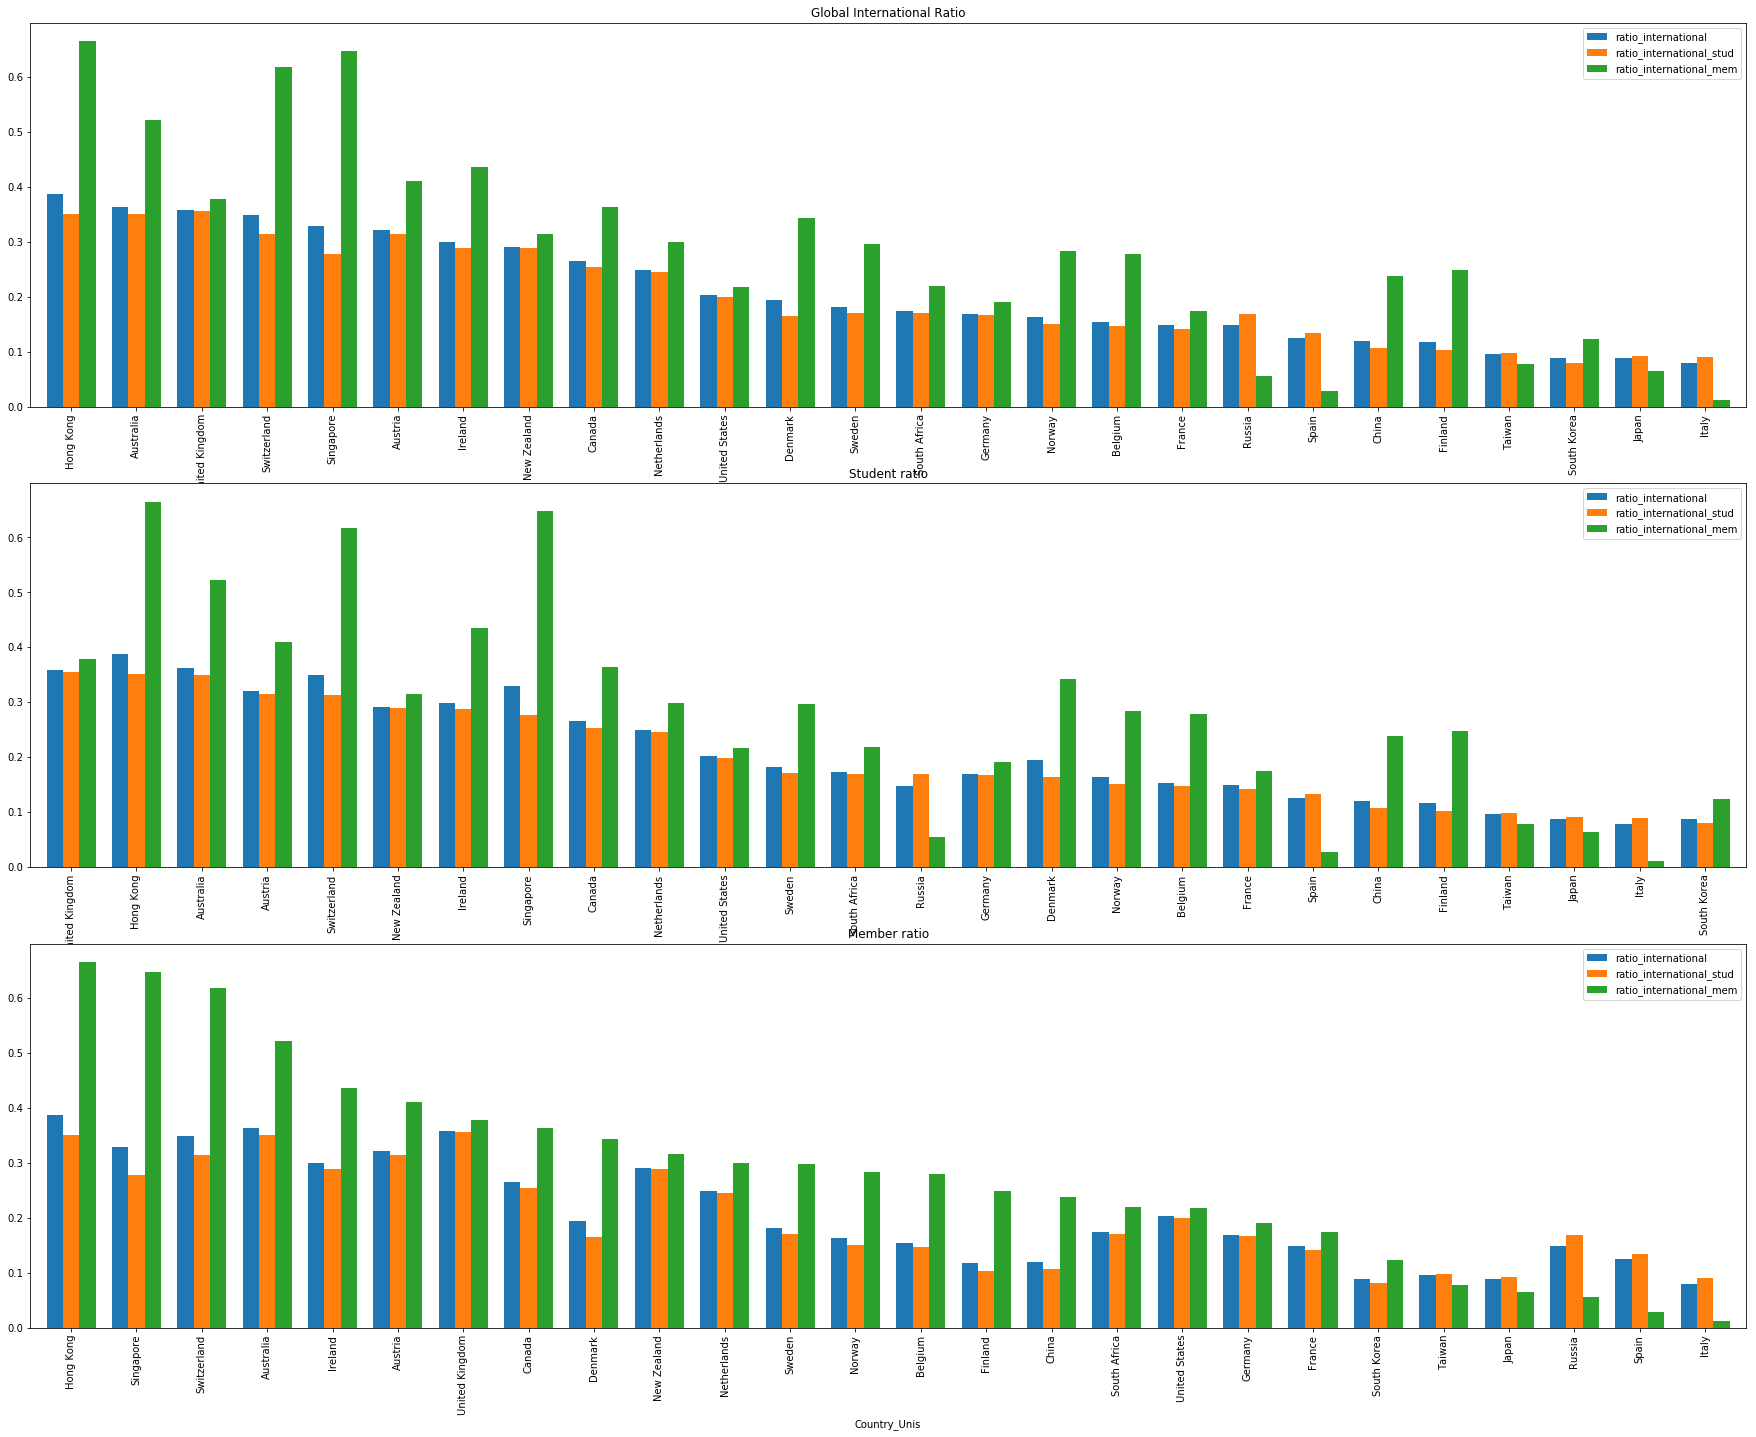

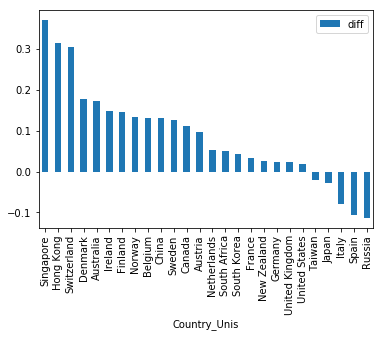

In [32]:
sorted_by_global_ratio = mean_ratio_by_country.sort_values("ratio_international", ascending=False)
sorted_by_stud_ratio = mean_ratio_by_country.sort_values("ratio_international_stud", ascending=False)
sorted_by_mem_ratio = mean_ratio_by_country.sort_values("ratio_international_mem", ascending=False)

mean_ratio_by_country["diff"] = mean_ratio_by_country["ratio_international_mem"] - mean_ratio_by_country["ratio_international_stud"]

rows = 3
fig, axes = plt.subplots(nrows=rows, ncols=1, figsize=(30.75,8 * rows), sharey=True)

sorted_by_global_ratio.plot.bar(y=columns, width=0.75, ax=axes[0], title="Global International Ratio")
sorted_by_stud_ratio.plot.bar(y=columns, width=0.75, ax=axes[1], title="Student ratio")
sorted_by_mem_ratio.plot.bar(y=columns, width=0.75, ax=axes[2], title="Member ratio")

mean_ratio_by_country.sort_values("diff", ascending=False).plot.bar(y="diff")
plt.show()

This last plot told us we could check the correlation with this difference of ratio and the ranking. But it did not work out. Let's see

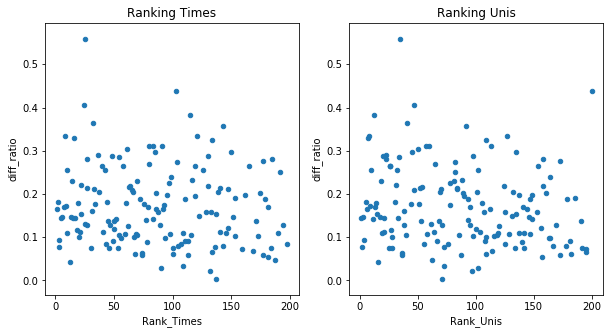

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

merged_df["diff_ratio"] = merged_df["ratio_international_stud_total"] - merged_df["ratio_international_mem_total"]
merged_df.plot(kind="scatter", x="Rank_Times", y="diff_ratio", ax=axes[0], title="Ranking Times")
merged_df.plot(kind="scatter", x="Rank_Unis", y="diff_ratio", ax=axes[1], title="Ranking Unis")

# Ratio of student to member per ranking 

One of the column in the Times ranking is the amount of staff per student. We did not have this information in the dataframe, but one estimation would be to get the amount of student over the amount of members. We did not obtain any correlation both globally, or by regions.

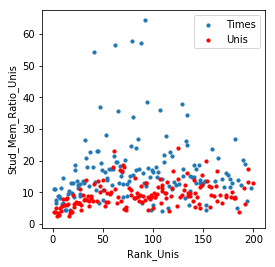

In [34]:
merged_df["Stud_Mem_Ratio_Times"] = merged_df["Tot_Stud_Times"] / merged_df["Tot_Mem_Times"]
merged_df["Stud_Mem_Ratio_Unis"] = merged_df["Tot_Stud_Unis"] / merged_df["Tot_Mem_Unis"]

ax = merged_df.plot(kind="scatter", x="Rank_Times", y="Stud_Mem_Ratio_Times", label="Times", s=10, figsize=(4,4))
merged_df.plot(kind="scatter", x="Rank_Unis", y="Stud_Mem_Ratio_Unis", ax=ax, c="r", label="Unis", s=10)

# Ratio of student to member per ranking per region


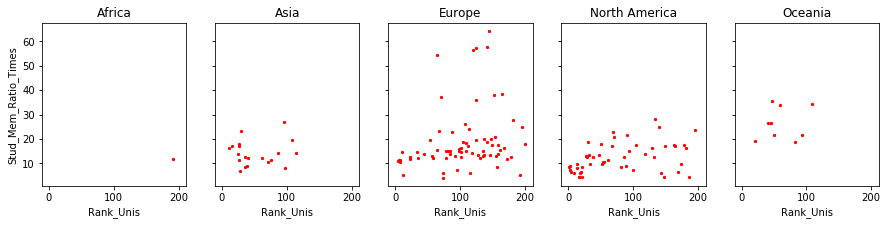

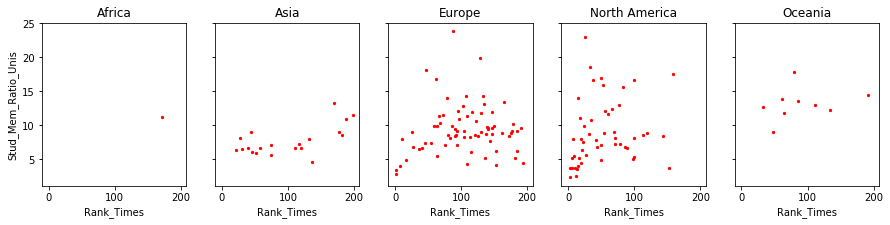

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True, sharex=True)

for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Unis", y="Stud_Mem_Ratio_Times", ax=axes[i], color="r", s=5)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True, sharex=True)

for i,(label,x) in enumerate(merged_df.groupby("Region_Unis")):
    x.plot(kind="scatter", title=label, x="Rank_Times", y="Stud_Mem_Ratio_Unis", ax=axes[i], color="r", s=5)

We can thus conclude our analysis by saying that theses variables does not explain by themselves the rankings. They don't even perform better in one ranking then in the other.

# 5. Can you find the best university taking in consideration both rankings? Explain your approach.

Wi find this as a highly subjective question. We could simply take the best university from the both rankings and pick two other variables to tie the result.

Instead we decided to pick the best university:

* The one with higher ranking, we pick the max of both rankings, `Our_Rank_Max_Rank` column
* The one where the both methodologies agree on (with the smallest absolute difference in ranking), thus, consistent result `Our_Rank_Difference_Rank` (it add weight to the fact would be better to take an university with rank 3 in both ranking than one with ranking 1 and ranking 6 for instance)
* The one that we can **access**, thus one with a high international student ratio, leaving your country to study in another is a marker of **strong** willingness, in addition, it follows the *vote with your feet*, the `Our_Rank_Max_Inter_Stud` column

To apply the ranking, we put all of those information, per university, in a vector and apply the euclidean norm (without the square root), since ranking and rank difference were ascending data, we do a $1 - ratio$ for the ratio of international people to also having the information in ascending order. Thus, the vector with the smallest norm is the one with the highest score

In [36]:
# Define our ranking columns data
merged_df["Our_Rank_Max_Rank"] = merged_df[["Rank_Times", "Rank_Unis"]].min(axis=1)

merged_df["Our_Rank_Difference_Rank"] = merged_df["Rank_Times"].apply(int) - merged_df["Rank_Unis"].apply(int)
merged_df["Our_Rank_Difference_Rank"] = merged_df["Our_Rank_Difference_Rank"].apply(np.abs)

merged_df["Our_Rank_Difference_Rank"] = merged_df["Our_Rank_Difference_Rank"].apply(np.abs)

merged_df["Our_Rank_Max_Inter_Stud"] = merged_df["ratio_international_stud"]


def rank(vec, max_rank_weight, abs_rank_diff_weight, ratio_inter_weight):
    
    
    max_rank, abs_rank_diff, ratio_inter = vec
    
    values = np.array([max_rank, abs_rank_diff, 1.0-ratio_inter])
    weights = np.array([max_rank_weight, abs_rank_diff_weight, ratio_inter_weight])

    
    return np.sum((values * weights) ** 2)

def rank_1(vec):
    return rank(vec, max_rank_weight=1, abs_rank_diff_weight=1, ratio_inter_weight=1)

def do_the_ranking(rank_f):
    cols = ["Our_Rank_Max_Rank", "Our_Rank_Difference_Rank", "Our_Rank_Max_Inter_Stud"]
    merged_df["Our_Rank_Agg"] = merged_df[cols].apply(rank_f, axis=1)

    cols = ["Name"] + cols + ["Our_Rank_Agg"]
    return merged_df.sort_values("Our_Rank_Agg")[:10][cols]
    
do_the_ranking(rank_1)

,Name,Our_Rank_Max_Rank,Our_Rank_Difference_Rank,Our_Rank_Max_Inter_Stud,Our_Rank_Agg
3,stanford university,2,1,0.227422,5.596877
2,california institute technology caltech,3,1,0.286918,10.508486
1,university cambridge,2,3,0.356899,13.413579
4,massachusetts institute technology mit,1,4,0.335863,17.441077
5,harvard university,3,3,0.234785,18.585554
0,university oxford,1,5,0.372870,26.393292
7,imperial college london,8,0,0.543567,64.208331
8,university chicago,9,0,0.249244,81.563635
6,princeton university,7,6,0.222208,85.604960
9,eth zurich swiss federal institute technology,10,0,0.381681,100.382319


We then though that 22.7% of international people ratio was a bit too low. Were we could go to Caltech by trading a single rank and get 6% better chance ot get accepted. We decided to increase the weight of international ratio:

In [37]:
def rank_2(vec):
    return rank(vec, max_rank_weight=0.5, abs_rank_diff_weight=1, ratio_inter_weight=5)

do_the_ranking(rank_2)

,Name,Our_Rank_Max_Rank,Our_Rank_Difference_Rank,Our_Rank_Max_Inter_Stud,Our_Rank_Agg
2,california institute technology caltech,3,1,0.286918,15.962150
3,stanford university,2,1,0.227422,16.921935
1,university cambridge,2,3,0.356899,20.339463
7,imperial college london,8,0,0.543567,21.208267
5,harvard university,3,3,0.234785,25.888838
4,massachusetts institute technology mit,1,4,0.335863,27.276936
8,university chicago,9,0,0.249244,34.340867
9,eth zurich swiss federal institute technology,10,0,0.381681,34.557974
0,university oxford,1,5,0.372870,35.082295
6,princeton university,7,6,0.222208,63.373992
